In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
import multiprocessing as mp
import time
import glob
import re
import random
from sklearn.model_selection import train_test_split
import torch

sys.path.insert(0, '/Data/user/panhailin/git_lab/npspy')
import npspy as nps

# 全局配置

In [2]:
torch.set_num_threads(10)

all_peps = [
    'hp1_1', 'hp1_2', 'hp1_3', 'hp1_4', 'hp1_5', 'hp1_6', 'hp1_7', 'hp1_8', 'hp1_9',
    'hp2_1', 'hp2_2', 'hp2_3', 'hp2_4', 'hp2_5', 'hp2_6',
]
y_code_dict = nps.ml.set_y_codes_for_classes(np.array(all_peps)[:,None])
y_code_dict
y_to_label_dict = {v:k for k,v in y_code_dict.items()}
y_code_dict, y_to_label_dict

({np.str_('hp1_1'): 0,
  np.str_('hp1_2'): 1,
  np.str_('hp1_3'): 2,
  np.str_('hp1_4'): 3,
  np.str_('hp1_5'): 4,
  np.str_('hp1_6'): 5,
  np.str_('hp1_7'): 6,
  np.str_('hp1_8'): 7,
  np.str_('hp1_9'): 8,
  np.str_('hp2_1'): 9,
  np.str_('hp2_2'): 10,
  np.str_('hp2_3'): 11,
  np.str_('hp2_4'): 12,
  np.str_('hp2_5'): 13,
  np.str_('hp2_6'): 14},
 {0: np.str_('hp1_1'),
  1: np.str_('hp1_2'),
  2: np.str_('hp1_3'),
  3: np.str_('hp1_4'),
  4: np.str_('hp1_5'),
  5: np.str_('hp1_6'),
  6: np.str_('hp1_7'),
  7: np.str_('hp1_8'),
  8: np.str_('hp1_9'),
  9: np.str_('hp2_1'),
  10: np.str_('hp2_2'),
  11: np.str_('hp2_3'),
  12: np.str_('hp2_4'),
  13: np.str_('hp2_5'),
  14: np.str_('hp2_6')})

In [3]:
train_objs = [f"../../../03.results/classification_on_clean_data/hp12/{pep}/{pep}_valid80_clean_obj.pkl" for pep in all_peps]
test_objs = [f"../../../03.results/classification_on_clean_data/hp12/{pep}/{pep}_valid20_clean_obj.pkl" for pep in all_peps]
labels = all_peps

In [4]:
def stratified_sample(df, column_name, sample_size=15000, random_state=42):
    """
    对DataFrame按指定列类别分层随机抽样
    
    参数:
        df: 输入DataFrame
        column_name: 分层依据的列名
        sample_size: 每类抽取样本数(默认15000)
        random_state: 随机种子
    
    返回:
        抽样后的新DataFrame
    """
    re_df = df.groupby(column_name, group_keys=True).apply(
        lambda x: x.sample(min(len(x), sample_size), 
                          random_state=random_state),
        include_groups=False,
    )
    re_df[re_df.index.names[0]] =  [i[0] for i in re_df.index]
    re_df.index = [i[1] for i in re_df.index]
    return re_df

# 读取pkl文件，生成readid，X，y组成的df

In [5]:
train_df = nps.ml.get_X_y_from_objs(objs=train_objs, labels=labels, y_code_dict=y_code_dict, down_sample_to=1000, att='signal')
train_df = stratified_sample(train_df, 'y', sample_size=25000, random_state=42)
train_df, valid_df = train_test_split(train_df, test_size=1/8, random_state=42, stratify=train_df['y'])
test_df = nps.ml.get_X_y_from_objs(objs=test_objs, labels=labels, y_code_dict=y_code_dict, down_sample_to=1000, att='signal')
test_df = stratified_sample(test_df, 'y', sample_size=6000, random_state=42)

# 通过data_df构建dataloader

In [10]:
batch_size = 128
train_dl = nps.ml.construct_dataloader_from_data_df(train_df, batch_size=batch_size, augment=False)
valid_dl = nps.ml.construct_dataloader_from_data_df(valid_df, batch_size=batch_size)
test_dl = nps.ml.construct_dataloader_from_data_df(test_df, batch_size=batch_size, shuffle=False)

# 初步训练

In [11]:
nps.ml.seed_everything(42)
clf = nps.ml.Trainer(lr=0.005, num_classes=len(all_peps), epochs=200, device='cuda', lr_scheduler_patience=3, label_smoothing=0.1, model_name='CNN1DL1000')
clf.fit(train_dl, valid_dl, early_stopping_patience=30, name='clean_data')

Model CNN1DL1000 has total parameter number: 6.21 M
Epoch   0 / 200 train_loss: 1.1765 train_acc: 0.7502 val_loss: 1.0903 val_acc: 0.7832 lr: 0.005
Epoch   1 / 200 train_loss: 0.8916 train_acc: 0.8720 val_loss: 1.1603 val_acc: 0.7499 lr: 0.005
Epoch   2 / 200 train_loss: 0.8187 train_acc: 0.9010 val_loss: 1.5012 val_acc: 0.6511 lr: 0.005
Epoch   3 / 200 train_loss: 0.7794 train_acc: 0.9160 val_loss: 0.7806 val_acc: 0.9125 lr: 0.005
Epoch   4 / 200 train_loss: 0.7528 train_acc: 0.9261 val_loss: 2.1566 val_acc: 0.4659 lr: 0.005
Epoch   5 / 200 train_loss: 0.7315 train_acc: 0.9344 val_loss: 0.9016 val_acc: 0.8544 lr: 0.005
Epoch   6 / 200 train_loss: 0.7159 train_acc: 0.9405 val_loss: 1.1812 val_acc: 0.7516 lr: 0.005
Epoch   7 / 200 train_loss: 0.7029 train_acc: 0.9456 val_loss: 0.7719 val_acc: 0.9143 lr: 0.005
Epoch   8 / 200 train_loss: 0.6910 train_acc: 0.9505 val_loss: 1.6486 val_acc: 0.5971 lr: 0.005
Epoch   9 / 200 train_loss: 0.6815 train_acc: 0.9546 val_loss: 0.7536 val_acc: 0.922

In [12]:
pred_df = clf.predict(test_dl, name='clean_data', y_to_label_dict=y_to_label_dict)
test_all_reads_s = pred_df['true'].value_counts()
cm_df = nps.ml.get_cm(pred_df, label_order=all_peps)
cm_df.to_csv("../../../04.tables/classification/hp12/hp_clean.csv")
print(cm_df)
print(np.sum(np.diag(cm_df))/len(pred_df))

 test_acc: 0.9523
pred   hp1_1  hp1_2  hp1_3  hp1_4  hp1_5  hp1_6  hp1_7  hp1_8  hp1_9  hp2_1  \
true                                                                          
hp1_1   5524     40     11      3     42      4      1      5      2      0   
hp1_2     56   5716     15      8      8      6      0      1      5      4   
hp1_3     15     15   5700      8     15     26      1     48    113      9   
hp1_4     18     19     19   5628      4     71      0     15     35     73   
hp1_5     39      8      8      7   5826     16      3      1      9      1   
hp1_6     14      4     34     67     17   5547      1     88    101     43   
hp1_7      1      0      2      1      2      0   5852      2      6      8   
hp1_8     10      1     44     16      1    126      1   5638    126     10   
hp1_9     12     14     80     14      7     93      2     69   5627      7   
hp2_1      0      6     14     59      0     26      6     12     14   5794   
hp2_2      3      5      1      5 

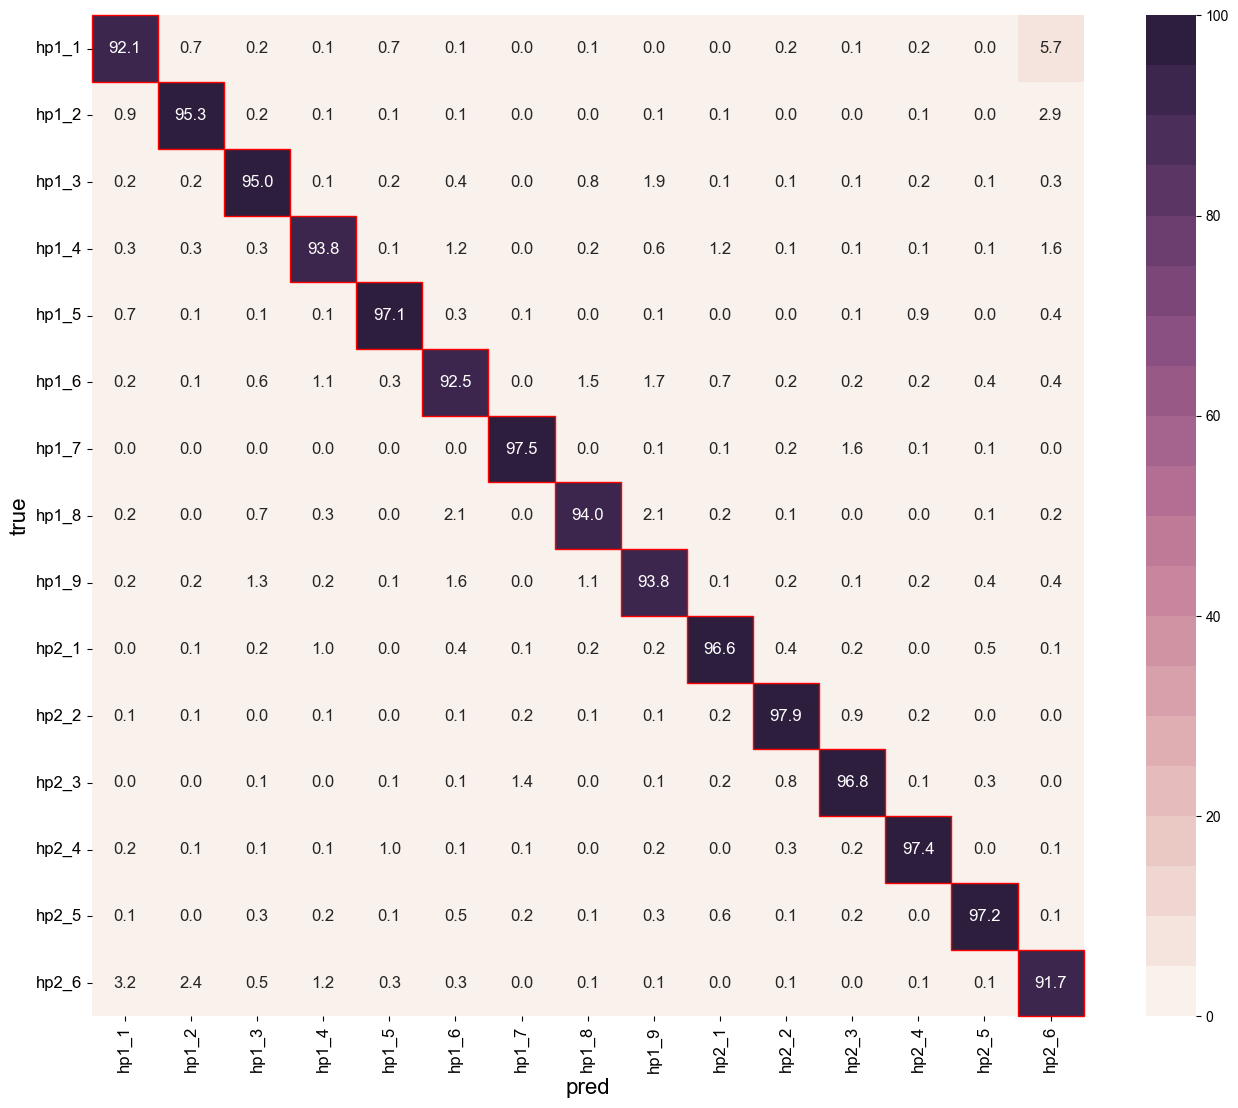

In [13]:
cm_df = pd.read_csv("../../../04.tables/classification/hp12/hp_clean.csv", index_col=0)
cm_df.columns.name = 'pred'
plt.rcParams['axes.labelsize'] = 16
nps.ml.plot_cm(cm_df, figsize=(16,13), nor_to_percent_for_each_pred=True, annot_size=12.0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('../../../05.figures/classification/hp12/hp12_clean_cm.pdf', bbox_inches='tight')

# 看预测概率的分布

In [14]:
nps.ml.seed_everything(42)
clf = nps.ml.Trainer(lr=0.005, num_classes=len(all_peps), epochs=200, device='cuda', lr_scheduler_patience=3, label_smoothing=0.1, model_name='CNN1DL1000')

Model CNN1DL1000 has total parameter number: 6.21 M


In [15]:
pred_proba_df = clf.predict_proba(test_dl, name='clean_data',)

 test_acc: 0.9523


<Axes: ylabel='Density'>

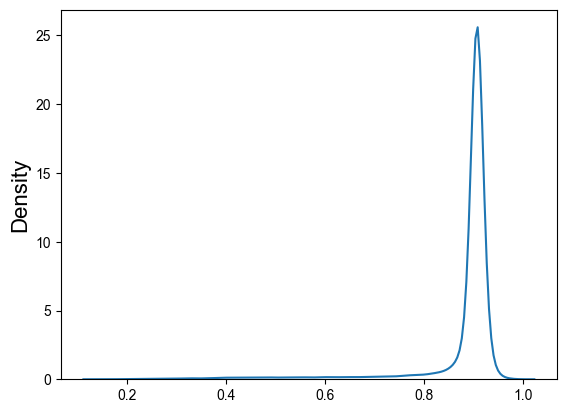

In [16]:
sns.kdeplot(pred_proba_df.iloc[:,0:-1].max(axis=1))